<a href="https://colab.research.google.com/github/Himank-J/ERAV2/blob/main/S8/ERAV2_S8_BN_Himank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [42]:
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784))
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784))
    ]
)


In [43]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [44]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


images.shape: torch.Size([128, 3, 32, 32])
labels.shape: torch.Size([128])


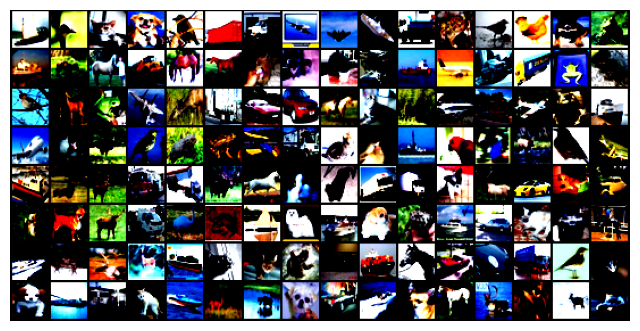

In [45]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, labels in train_loader:
  print('images.shape:', images.shape)
  print('labels.shape:', labels.shape)

  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0).clamp(0,1))
  break

In [46]:
import torch.nn as nn
import torch.nn.functional as F

dropout_value = 0.1

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
       # C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.pool1 = nn.MaxPool2d(2, 2)

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.pool2 = nn.MaxPool2d(2, 2)

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        )

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool1(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [47]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           2,304
             ReLU-12           [-1, 16, 16, 16]               0
      BatchNorm2d-13           [-1, 16, 16, 16]              32
          Dropout-14           [-1, 16,

In [48]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [49]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.429534673690796 Batch_id=390 Accuracy=42.80: 100%|██████████| 391/391 [00:17<00:00, 22.15it/s]



Test set: Average loss: 1.3264, Accuracy: 5188/10000 (51.88%)

EPOCH: 1


Loss=1.064324140548706 Batch_id=390 Accuracy=57.27: 100%|██████████| 391/391 [00:16<00:00, 23.60it/s]



Test set: Average loss: 1.2623, Accuracy: 5513/10000 (55.13%)

EPOCH: 2


Loss=0.9003901481628418 Batch_id=390 Accuracy=62.38: 100%|██████████| 391/391 [00:17<00:00, 22.74it/s]



Test set: Average loss: 1.0092, Accuracy: 6382/10000 (63.82%)

EPOCH: 3


Loss=0.9795568585395813 Batch_id=390 Accuracy=65.35: 100%|██████████| 391/391 [00:16<00:00, 23.84it/s]



Test set: Average loss: 0.9856, Accuracy: 6439/10000 (64.39%)

EPOCH: 4


Loss=0.924956202507019 Batch_id=390 Accuracy=67.30: 100%|██████████| 391/391 [00:16<00:00, 23.46it/s]



Test set: Average loss: 0.9050, Accuracy: 6725/10000 (67.25%)

EPOCH: 5


Loss=0.7798824310302734 Batch_id=390 Accuracy=69.13: 100%|██████████| 391/391 [00:17<00:00, 21.79it/s]



Test set: Average loss: 0.8739, Accuracy: 6892/10000 (68.92%)

EPOCH: 6


Loss=0.778124988079071 Batch_id=390 Accuracy=72.45: 100%|██████████| 391/391 [00:16<00:00, 23.13it/s]



Test set: Average loss: 0.8095, Accuracy: 7104/10000 (71.04%)

EPOCH: 7


Loss=0.6508065462112427 Batch_id=390 Accuracy=72.85: 100%|██████████| 391/391 [00:17<00:00, 22.23it/s]



Test set: Average loss: 0.8028, Accuracy: 7127/10000 (71.27%)

EPOCH: 8


Loss=0.6505192518234253 Batch_id=390 Accuracy=73.26: 100%|██████████| 391/391 [00:17<00:00, 22.87it/s]



Test set: Average loss: 0.8043, Accuracy: 7134/10000 (71.34%)

EPOCH: 9


Loss=0.7350993752479553 Batch_id=390 Accuracy=73.62: 100%|██████████| 391/391 [00:16<00:00, 23.00it/s]



Test set: Average loss: 0.7950, Accuracy: 7162/10000 (71.62%)

EPOCH: 10


Loss=0.9457350969314575 Batch_id=390 Accuracy=73.75: 100%|██████████| 391/391 [00:18<00:00, 21.62it/s]



Test set: Average loss: 0.7860, Accuracy: 7179/10000 (71.79%)

EPOCH: 11


Loss=0.9205427169799805 Batch_id=390 Accuracy=73.84: 100%|██████████| 391/391 [00:17<00:00, 22.87it/s]



Test set: Average loss: 0.7866, Accuracy: 7204/10000 (72.04%)

EPOCH: 12


Loss=0.827477753162384 Batch_id=390 Accuracy=74.25: 100%|██████████| 391/391 [00:17<00:00, 22.77it/s]



Test set: Average loss: 0.7794, Accuracy: 7211/10000 (72.11%)

EPOCH: 13


Loss=0.92839115858078 Batch_id=390 Accuracy=74.60: 100%|██████████| 391/391 [00:18<00:00, 21.38it/s]



Test set: Average loss: 0.7790, Accuracy: 7224/10000 (72.24%)

EPOCH: 14


Loss=0.5996055006980896 Batch_id=390 Accuracy=74.62: 100%|██████████| 391/391 [00:17<00:00, 22.54it/s]



Test set: Average loss: 0.7826, Accuracy: 7207/10000 (72.07%)

EPOCH: 15


Loss=0.8561137914657593 Batch_id=390 Accuracy=74.53: 100%|██████████| 391/391 [00:18<00:00, 21.43it/s]



Test set: Average loss: 0.7692, Accuracy: 7249/10000 (72.49%)

EPOCH: 16


Loss=0.6816343069076538 Batch_id=390 Accuracy=74.38: 100%|██████████| 391/391 [00:18<00:00, 20.74it/s]



Test set: Average loss: 0.7780, Accuracy: 7208/10000 (72.08%)

EPOCH: 17


Loss=0.6978715062141418 Batch_id=390 Accuracy=74.57: 100%|██████████| 391/391 [00:18<00:00, 21.06it/s]



Test set: Average loss: 0.7757, Accuracy: 7220/10000 (72.20%)

EPOCH: 18


Loss=1.0180073976516724 Batch_id=390 Accuracy=74.65: 100%|██████████| 391/391 [00:17<00:00, 21.74it/s]



Test set: Average loss: 0.7784, Accuracy: 7213/10000 (72.13%)

EPOCH: 19


Loss=0.9017895460128784 Batch_id=390 Accuracy=74.75: 100%|██████████| 391/391 [00:17<00:00, 21.95it/s]



Test set: Average loss: 0.7767, Accuracy: 7210/10000 (72.10%)



In [50]:
train_losses_tensor = torch.tensor(train_losses).cuda()
train_losses_tensor = train_losses_tensor.cpu().numpy()

train_acc_tensor = torch.tensor(train_acc).cuda()
train_acc_tensor = train_acc_tensor.cpu().numpy()

test_losses_tensor = torch.tensor(test_losses).cuda()
test_losses_tensor = test_losses_tensor.cpu().numpy()

test_acc_tensor = torch.tensor(test_acc).cuda()
test_acc_tensor = test_acc_tensor.cpu().numpy()

Text(0.5, 1.0, 'Test Accuracy')

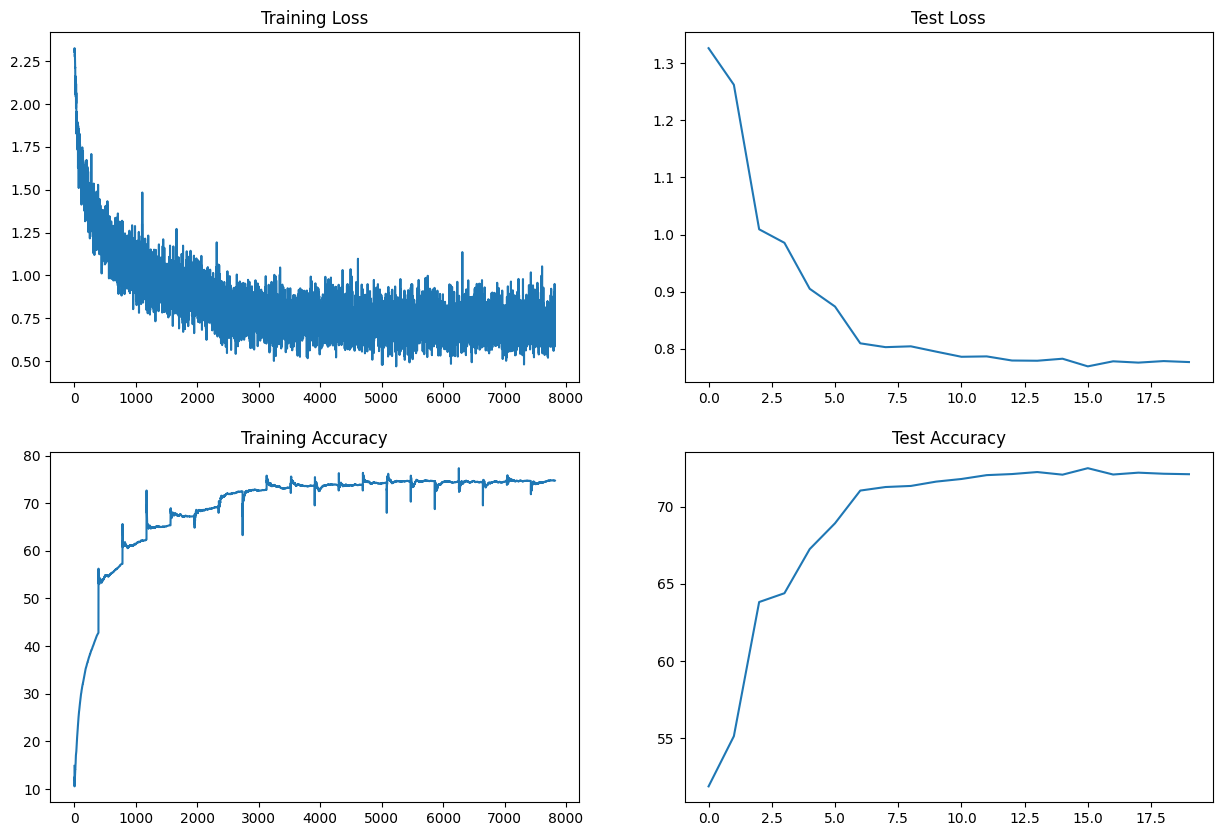

In [51]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_tensor)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_tensor)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_tensor)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_tensor)
axs[1, 1].set_title("Test Accuracy")